**Проект Яндекс.Практикума. Как рассказать историю с помощью данных**

**Курс: Аналитик данных**

---



**СОДЕРЖАНИЕ**

---
[**Описание проекта**](#description)

[**Импорт библиотек и загрузка данных**](#loading)

[**Предобработка данных**](#preparing)

[**Исследовательский анализ данных (EDA)**](#EDA)

[**Выводы и рекомендации**](#summary)

---




**МАТЕРИАЛЫ К ПРОЕКТУ**

<a  href='https://drive.google.com/file/d/1FryM6u8NUOufqmOMk3SxVZOqEN3CQ93E/view?usp=sharing'>Ссылка на файл с презентацией</a> 

---



---



## **Описание проекта**<a  class="anchor" id="description"></a>

##  **Импорт библиотек и загрузка данных**<a  class="anchor" id="loading"></a>

In [1]:
# импортируем библиотеки для работы с данными, построения моделей и визуализации информации
import gdown

import pandas as pd
import datetime as dt

import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go

import folium
from folium.features import DivIcon

import numpy as np
from scipy import stats as st

import warnings
warnings.filterwarnings("ignore")

In [2]:
# устанавливаем параметры отображения данных
pd.set_option("precision", 2)
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_colwidth', 40)
pd.set_option('display.width', 120)

matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

sns.set(style="whitegrid", font_scale=1.5)

**Загрузка данных**

Примем уникальный идентификатор объекта в качестве индекса при загрузке данных. 

Информация о дате регистрации объекта в базе даных не предоставлена. Предполагаем, что один и тот же объект (название, атрибуты принадлежности к сети и типа заведения, а так же адрес и количество посадочных мест совпадают) может быть зарегистрирован несколько раз (например, при смене собственника). Тогда использование ID в качестве индекса позволит исключить записи с идентичными полями. 

In [3]:
# Функция для подготовки ссылки для загрузки файлов с гугл-диска
def gdisk_gownload(link):
    return 'https://drive.google.com/uc?id=' + link.split('/')[-2]

In [4]:
try:
    rest_data=pd.read_csv(' ',index_col='id')
    
except:
    rest_data=pd.read_csv(gdisk_gownload(' '),index_col='id')

Загружаем файл с геоданными для адресов, расположенных на улицах Москвы с набольшей и наименьшей концентрацией заведений общепита, (подготовлен отдельно с использованием библиотеки https://pypi.org/project/yandex-geocoder/).

In [5]:
one_obj_street_coords = pd.read_csv(gdisk_gownload('https://drive.google.com/file/d/1TIk3W-1Y56Aa6t3XXQyYyuwuLVmyRSbD/view?usp=sharing'),index_col='Unnamed: 0')

In [6]:
top_ten_street_coord = pd.read_csv(gdisk_gownload('https://drive.google.com/file/d/1bHd84wbvHuDZpt11q2D9ZLsldeTK_Hls/view?usp=sharing'),index_col='Unnamed: 0')


## **Предобработка данных**<a  class="anchor" id="preparing"></a>

In [7]:
# функция для получения информации о структуре и составе данных
def check_dataset(dataset):
    try:
        print('\033[1m','Случайные 5 строк таблицы:','\033[0m')
        print(dataset.sample(n=5,random_state=42))
        print('\033[1m','\nИнформация о типах данных:', '\033[0m')
        dataset.info()
        if dataset.isna().mean().sum()==0:
            print('\033[1m', '\nПропусков в столбцах НЕТ', '\033[0m')
        else:
            print('\033[1m', '\nДоля пропусков в столбцах:', '\033[0m')
            print(pd.DataFrame(round((dataset.isna().mean()*100),2)))
        if dataset.duplicated().sum()==0:
            print('\033[1m', '\nДубликатов строк НЕТ', '\033[0m')
        else:
            print('\033[1m', '\nКоличество дубликатов:', '\033[0m',dataset.duplicated().sum())
           
    except:
        print('Ошибка')

Проверка таблицы **"Rest_data"**:

In [8]:
check_dataset(rest_data)

 Случайные 5 строк таблицы: 
                  object_name chain                object_type                                  address  number
id                                                                                                             
182973            БУРГЕР КИНГ    да                       кафе  город Москва, Ярославское шоссе, дом 69      60
156321       Кафе «Тетя Мотя»   нет                       кафе  город Москва, проезд Сокольнического...     100
206042             Чебуречная   нет  магазин (отдел кулинарии)  город Москва, Открытое шоссе, дом 9,...       0
156891   Чудо Пекарня Шаргунь   нет                 закусочная  город Москва, Севастопольский проспе...       0
27730   Столовая «ГАЛА ПИЦЦА»   нет                   столовая  город Москва, Варшавское шоссе, дом 116      46
 
Информация о типах данных: 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 15366 entries, 151635 to 222535
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
--

В таблице Rest_data типы данных соотвествуют описанию, пропусков в столбцах нет.
Удалим дублированные записи в количестве 82 шт.:

In [9]:
rest_data.drop_duplicates(inplace=True);



---



---





## **Исследовательский анализ данных (EDA)**<a  class="anchor" id="EDA"></a>



### **Исследование соотношения видов объектов общественного питания по количеству**

Создадим сводную таблицу, сгруппировав заведения общественного питания по типу и подсчитав их количество. 

Для удобства визуализации, заменим длинные наименования типов 'магазин (отдел кулинарии)' и 'предприятие быстрого обслуживания' на эквивалентные им 'кулинария' и 'фаст-фуд'.

In [10]:
object_type_pivot=rest_data.pivot_table(index='object_type',values='number',aggfunc='count').reset_index()
object_type_pivot.object_type=object_type_pivot.object_type.replace(['магазин (отдел кулинарии)','предприятие быстрого обслуживания'],['кулинария','фаст-фуд'])

Для оптимизации кода выдлим настройку параметров графиков в отдельную функцию.

In [11]:
def plot_attr(x,y,dataset,title,xlabel,ylabel,hue=None,figsize=(20, 8),rotation=0):
    fig,ax = plt.subplots(figsize=figsize)
    ax=sns.barplot(x, y, hue=hue, data=dataset)
    ax.title.set_text(title)
    ax.title.set_fontsize(20)
    ax.title.set_color('red')
    ax.set_xlabel(xlabel,fontsize=14,color='red')
    ax.set_ylabel(ylabel,fontsize=14,color='red')
    if hue==None:
        for i, v in enumerate(dataset[y]):
            if isinstance(v, float): v=round(v,2)
            ax.text(i-0.1,v*1.01, str(v), fontsize=14,color='black')
    ax.set_facecolor('azure')
    plt.xticks(rotation=rotation)
    fig.show() 

Построим графк отображающий соотношение видов объектов общественного питания  в г. Москва.

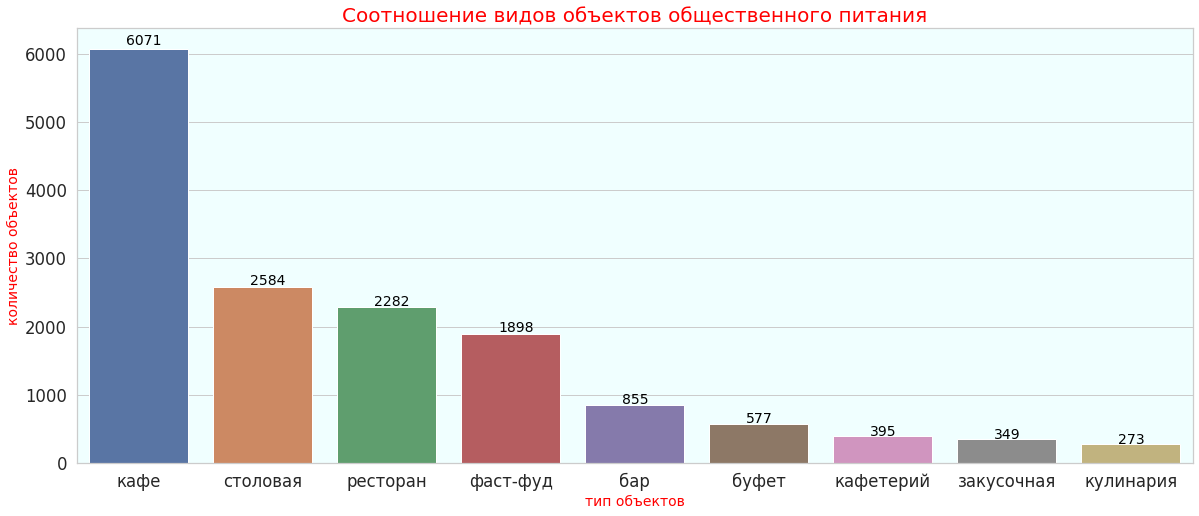

In [12]:
x='object_type'
y='number'
dataset=object_type_pivot.sort_values('number',ascending=False)
title='Соотношение видов объектов общественного питания'
xlabel='тип объектов'
ylabel='количество объектов'
plot_attr(x,y,dataset,title,xlabel,ylabel)


Самыми многочисленными видами объектов общественного питания на карте г. Москва являются кафе, столовые, рестораны и заведения, осуществляющие быстрое приготовление пищи с минимальным или отсутствующим обслуживанием клиентов по приему заказов, подаче и уборке блюд.


---



### **Исследование соотношения сетевых и несетевых заведений по количеству**

Построим диаграмму соотношения сетевых и несетевых заведений общественного питания г. Москвы по количеству.

In [13]:
chain_stat = ['Сетевые объекты','Индивидуальные объекты']
values = [rest_data[rest_data.chain=='да']['chain'].count(), rest_data[rest_data.chain=='нет']['chain'].count()]
#fig = px.pie(values=values, names=chain_stat, color_discrete_sequence=px.colors.sequential.RdBu)
fig = go.Figure(data=[go.Pie(labels=chain_stat, values=values)])
fig.layout.title="Соотношение сетевых и несетевых заведений"
fig.update_layout(
    autosize=False,
    width=600,
    height=600,
    title_font_color="red",
)
fig.show() 

Пятая часть обектов общественного питания г. Москвы входит в состав сетей подобных заведений.

---



### **Исследование сетевых заведений общественного питания**

Для оценки сетевого распространения заведений по видам объектов общественного питания создадим сводную таблицу, сгруппировав данные по видам и принадлежности к сетям. Подсчитаем количество заведений по соотвествию этим признакам.

In [14]:
net=rest_data.groupby(['object_type','chain'])['number'].agg('count')
net=net.reset_index()
net.object_type=net.object_type.replace(['магазин (отдел кулинарии)','предприятие быстрого обслуживания'],['кулинария','фаст-фуд'])

Построим график соотношения количества сетевых и несетевых заведений общественного питания по видам.

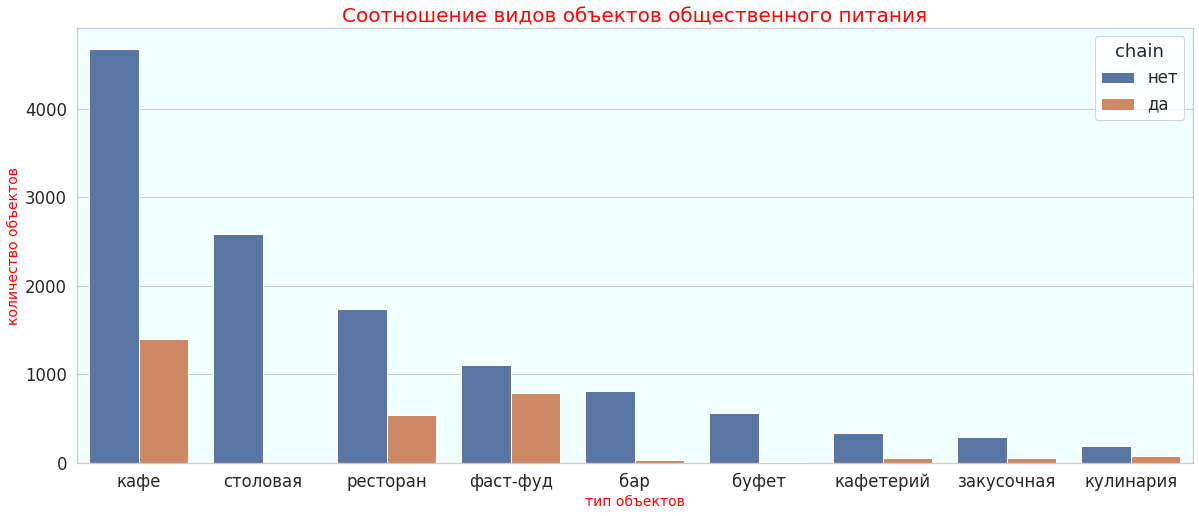

In [15]:
x='object_type'
y='number'
hue='chain'
dataset=net.sort_values('number',ascending=False)
title='Соотношение видов объектов общественного питания'
xlabel='тип объектов'
ylabel='количество объектов'
plot_attr(x,y,dataset,title,xlabel,ylabel,hue)

В абсолютных цифрах "рекордсменами" по количеству сетевых заведений являются кафе, предприятия быстрого обслуживания и рестораны.

---



Определим долю сетевых заведений в общем количестве объектов общественного питания по видам.

In [16]:
net_ratio=net.query('chain=="да"')
net_ratio=net_ratio[['object_type','number']]
net_ratio=net_ratio.merge(net.groupby('object_type')['number'].agg('sum').reset_index(),on='object_type')
net_ratio['ratio']=net_ratio.number_x/net_ratio.number_y

Построим график доли сетевых заведений общественного питания по видам.

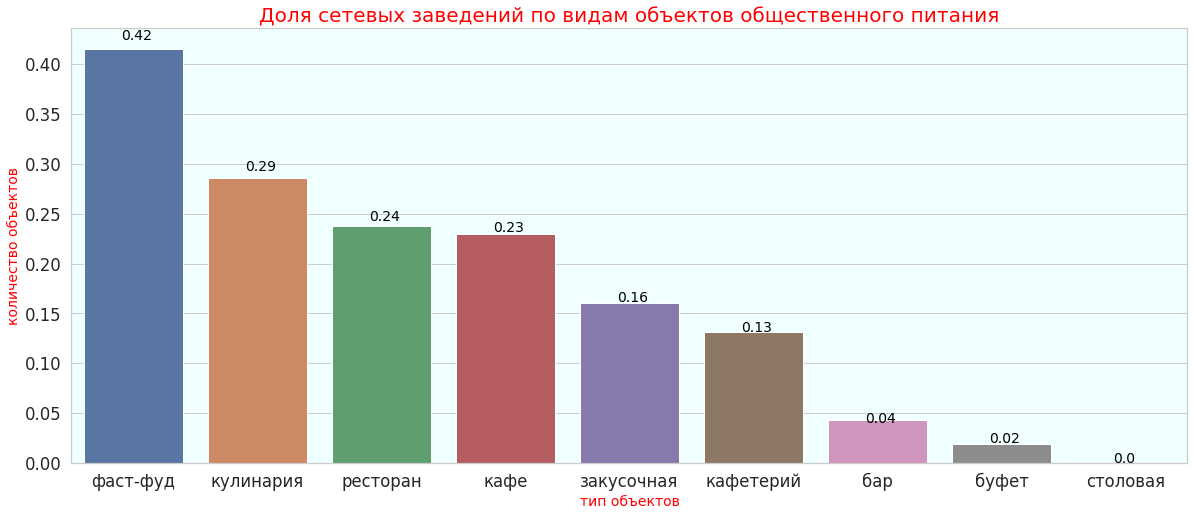

In [17]:
x='object_type'
y='ratio'
dataset=net_ratio.sort_values('ratio',ascending=False)
title='Доля сетевых заведений по видам объектов общественного питания'
xlabel='тип объектов'
ylabel='количество объектов'
plot_attr(x,y,dataset,title,xlabel,ylabel)

Более 40% предприятий фаст-фуда принадлежат сетям, благодаря простоте концепции, стандартизированным бизнес-процессам, цепочкам поставок, не зависящим от дефицитных продуктов, и сниженным требованиям к квалификации персонала.

Сравнительно высокая доля сетевой концентрации у ресторанов и кафе (более 20%) и закусочных (скорее всего с моно-концепцией, доля более 15%).

Тот факт, что более четверти кулинарий г. Москвы принадлежат сетям, объясняется наличием практически в каждом гипермаркете крупных ритейлеров соответствующего отдела. 

---



Для анализа сетевых объектов общественногопитания по количеству посадочных мест создадим сводную таблицу, сгруппировав предприятия сетей по вместимости и рассчитав их количество по группам.

In [18]:
network=rest_data.query('chain=="да"')

In [19]:
network.number.describe()

count    2964.00
mean       52.98
std        57.15
min         0.00
25%        15.00
50%        40.00
75%        72.00
max       580.00
Name: number, dtype: float64

Медианным значением вместимости для сетевых заведений общественного питания г. Москвы является количество посадочных мест не более 40, а в среднем - около 53.

Сравним среднюю и меданную вместимости, рассчитанные для **всех** объектов в базе данных с показателями, характерными для сетевых заведений.

In [20]:
rest_data.number.describe()

count    15284.00
mean        59.78
std         74.84
min          0.00
25%         14.00
50%         40.00
75%         80.00
max       1700.00
Name: number, dtype: float64

Сформулируем нулевую гипотезу, что нет никаких различий в средних значениях количества посадочных мест для сетевых заведений от средних значений вместимости, характерной для несетевых заведений.

Для проверки нулевой гипотезы применим критерий Манна-Уитни. Пороговый уровень значимости примем в 5% (alpha=0.05). 

In [21]:
print("p-value: {0:.3f}".format(st.mannwhitneyu(rest_data.query('chain=="нет"').number, network.number)[1]))

p-value: 0.158


**Вывод:** не отвергаем нулевую гипотезу. Нельзя утверждать, что средние значения вместимости сетевых завдений общественного питания в г. Москва отличаются от показателей остальных объектов.

Построим распределение объектов общественного питания, входящих в сети, по вместимости.

In [22]:
network_pivot=network.pivot_table(index='number',values='chain',aggfunc='count').reset_index()

In [23]:
def scat_attr(x,y,title,xlabel,ylabel,figsize=(20, 8)):
    with sns.axes_style("dark"):
        fig,ax = plt.subplots(figsize=figsize)
        ax=sns.scatterplot(x, y, s=70)
        ax.title.set_text(title)
        ax.title.set_fontsize(20)
        ax.title.set_color('red')
        ax.set_xlabel(xlabel,fontsize=14,color='red')
        ax.set_ylabel(ylabel,fontsize=14,color='red')
        fig.show() 

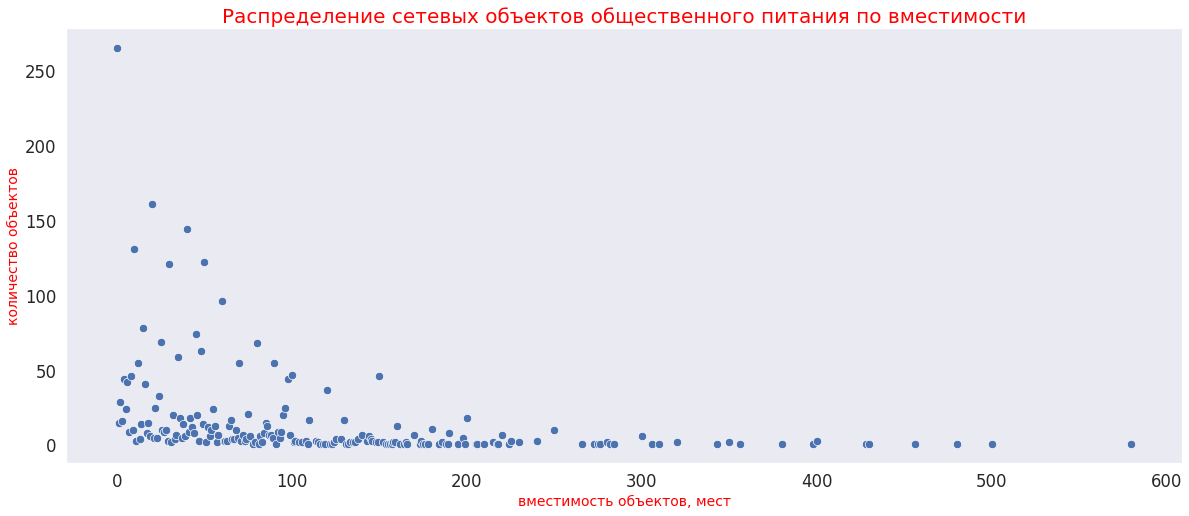

In [24]:
x=network_pivot.number
y=network_pivot.chain
title='Распределение сетевых объектов общественного питания по вместимости'
xlabel='вместимость объектов, мест'
ylabel='количество объектов'
scat_attr(x,y,title,xlabel,ylabel)


In [25]:
print("Доля сетевых заведений без зала для обслуживания клиентов: {:.1%}".format(network_pivot.query('number==0')['chain'].values[0]/network_pivot.chain.sum()))

Доля сетевых заведений без зала для обслуживания клиентов: 8.9%


Большая часть данных сгруппировалась в левой нижней четверти графика. Это поволяет заключить, что для сетевых предприятий общественного питания характерна вместимость в диапазоне от 0 до 200 посадочных мест.

Так как величины вместимости объектов общественного питания регламентируютя только в зависимости от характеристик объектов недвижимости, для того чтобы увеличить плотность данных для визуализации, сгруппируем заведения по количеству посадочных мест выделив четыре диапазона.

Правой границей диапазона количества посадочных мест, превышающего 200, примем максимальную вместимость сетевого заведения г. Москвы.

In [26]:
print('Максимальная вместимость сетевого объекта: ', network_pivot.number.max())

Максимальная вместимость сетевого объекта:  580


In [27]:
cut_labels = ['до 50', '51-100', '101-200', '201-580']
cut_bins=[-1,50, 100, 200, 580]
network['capacity_cat']=pd.cut(network['number'], bins=cut_bins,labels=cut_labels)

Построим график распрелеления сетевых объектов общественного питания г. Москвы по группам вместимости.

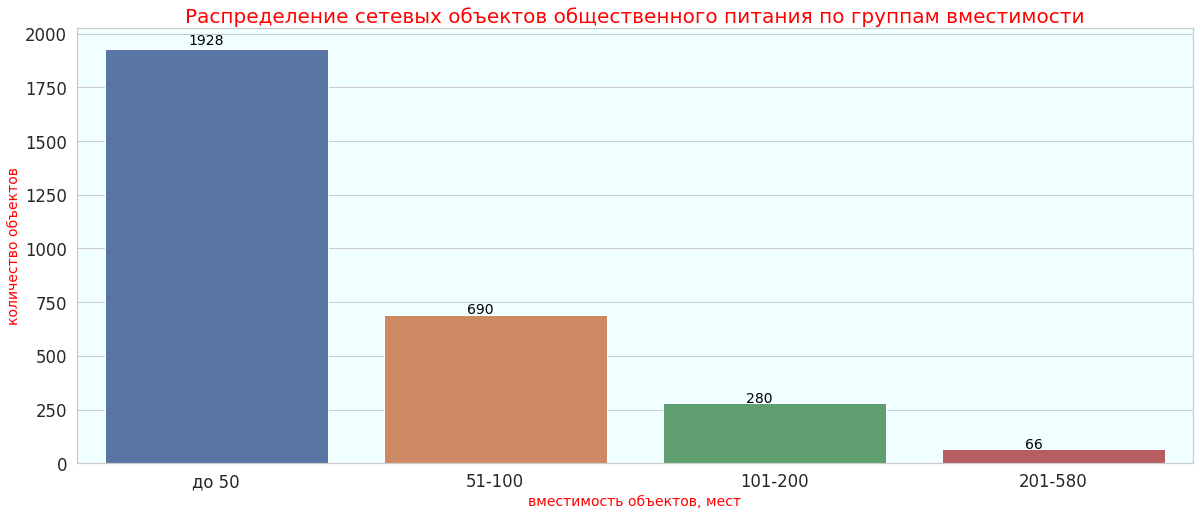

In [28]:
x='capacity_cat'
y='chain'
dataset=network.groupby(['capacity_cat'])['chain'].agg('count').reset_index()
title='Распределение сетевых объектов общественного питания по группам вместимости'
xlabel='вместимость объектов, мест'
ylabel='количество объектов'
plot_attr(x,y,dataset,title,xlabel,ylabel)

График подтверждает ранее сделанный вывод, что абсолютное большинство сетевых заведений общественного питания г. Москвы имеют обеденные залы, рассчитанные не более чем на 100 посадочных мест.

### **Исследование средней вместимости для предпрития общественного питания разных видов**

Определим среднее количество посадочных мест характерное для заведений общепита разных видов. Для этого сформируем сводную таблицу, сгруппировав данные по видам объектов общественного питания и рассчитав минимальную, среднюю и максимальную вместимость.

In [29]:
object_type_number=rest_data.groupby(['object_type'])['number'].agg(['min','mean','max']).reset_index()
object_type_number.object_type=object_type_number.object_type.replace(['магазин (отдел кулинарии)','предприятие быстрого обслуживания'],['кулинария','фаст-фуд'])
object_type_number['mean']=np.ceil(object_type_number['mean']).astype('int')

In [30]:
object_type_number

,object_type,min,mean,max
0,бар,0,44,1700
1,буфет,0,52,320
2,закусочная,0,8,216
3,кафе,0,40,533
4,кафетерий,0,10,200
5,кулинария,0,6,50
6,фаст-фуд,0,21,580
7,ресторан,0,97,1500
8,столовая,0,131,1400


Заведения в которых обеденный зал отсуствует характерны для объектов всех видов. Можно предположить, что для некоторых видов это является недостатком сбора данных.

Максимальная вместимость, превышающая почти втрое величины следующие в ряду, в данных указана для одного ресторана (Банкетный зал Шелк, на дату исследования закрыт), столовой (Столовая-Буфет у храма Христа-Спасителя) и бара (концертная площадка Арена Сохо).

In [31]:
rest_data.query('number==1700 or number==1500 or number==1400')

,object_name,chain,object_type,address,number
id,,,,,
80291,Банкетный зал Шелк,нет,ресторан,"город Москва, Большой Саввинский пер...",1500
27750,СТОЛОВАЯ-БУФЕТ,нет,столовая,"город Москва, улица Волхонка, дом 15",1400
199696,Arena by Soho Family,нет,бар,"город Москва, Кутузовский проспект, ...",1700


Постром график распределения средней вместимости по видам объектов общественного питания.

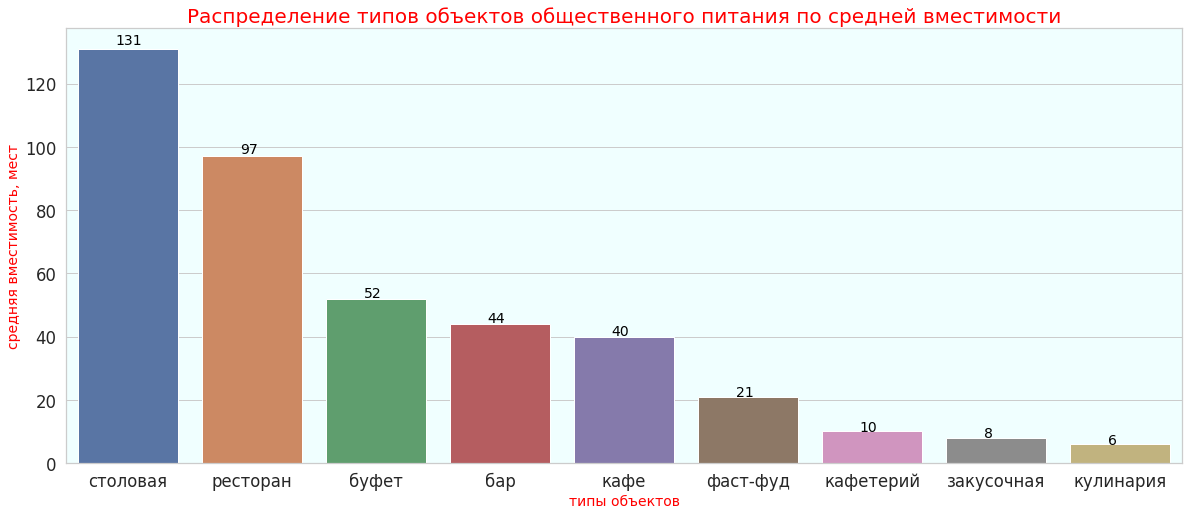

In [32]:
x='object_type'
y='mean'
dataset=object_type_number.sort_values('mean',ascending=False)
title='Распределение типов объектов общественного питания по средней вместимости'
xlabel='типы объектов'
ylabel='средняя вместимость, мест'
plot_attr(x,y,dataset,title,xlabel,ylabel)

Не принимая во внимание влияние на средние значения описанные ранее аномальные максимумы количества посадочных мест, высокая средняя вместимость жарактерна для объектов испытывающих высокие пиковые нагрузки посещаемости:
- столовые (бизнес-ланч, обед);
- рестораны (фуршеты, банкеты, торжества);
- буфеты (перерывы во время различных мероприятий).

Более равномерно загруженные в течение дня/недели типф заведений общественного питания имеют в среднем количествопосадочных мест не превышающее 20.

---



### **Исследование географического положения объектов общественного питания г. Москвы**

В данных у некоторых записей в поле адреса информация внесена неполно: не указан населенный пункт.Таких записей 71, мы их отметили флагом True по созданному полю "Wrong_address".

In [33]:
rest_data['wrong_address']=rest_data.apply(lambda x:x.address.split(',')[0].strip()!='город Москва',axis=1)
rest_data['wrong_address'].sum()

71

Пользуясь тем фактом, что предоставленная база данных сождержит информацию о заведениях общепита, расположенных в г. Москва, внесем изменения и добавим наименование населенного пункта в начало адреса для 71 записи.

In [34]:
rest_data['address']=rest_data.apply(lambda x: 'город Москва, '+x.address if x.address.split(',')[0].strip()!='город Москва' else x.address,axis=1)
rest_data.drop('wrong_address',axis=1);

Для дальнейшего анализа расположения объектов общественого питания на катре г. Москвы, выделим из адреса в отдельный столбец наименование улицы.

In [35]:
rest_data['street']=rest_data.apply(lambda x: x.address.split(',')[1].strip(),axis=1)

Вынесем в отдельную переменную наименования улиц и количество заведений общественного питания на них расположенных.

In [36]:
street_dist=rest_data.groupby('street')['object_name'].count().reset_index().sort_values('object_name',ascending=False)
street_dist.columns=['street','obj_count']

In [37]:
street_dist.head()

,street,obj_count
1333,город Зеленоград,232
1406,проспект Мира,204
996,Профсоюзная улица,182
683,Ленинградский проспект,172
981,Пресненская набережная,167


КЛАДР включает в черту города Москва 59 обособленных территориальных единиц (города, поселения, поселки, деревни и территорию). Для соотвествия заявленным целям, ограничим исследование адресами объектов, расположенных в пределах МКАД.

In [38]:
not_street=['деревня','поселок','территория','город','поселение']
street_dist_city=street_dist[(street_dist['street'].str.contains('|'.join(not_street)) == False)]

Определим ТОП-10 улиц г. Москвы по количеству расположенных на них объектов общественного питания.

In [39]:
top_ten_street=street_dist_city.nlargest(10,'obj_count').reset_index(drop=True)

In [40]:
top_ten_street

,street,obj_count
0,проспект Мира,204
1,Профсоюзная улица,182
2,Ленинградский проспект,172
3,Пресненская набережная,167
4,Варшавское шоссе,162
5,Ленинский проспект,148
6,проспект Вернадского,128
7,Кутузовский проспект,114
8,Каширское шоссе,111
9,Кировоградская улица,108


Построим график топ-10 улиц по количеству объектов общественного питания.

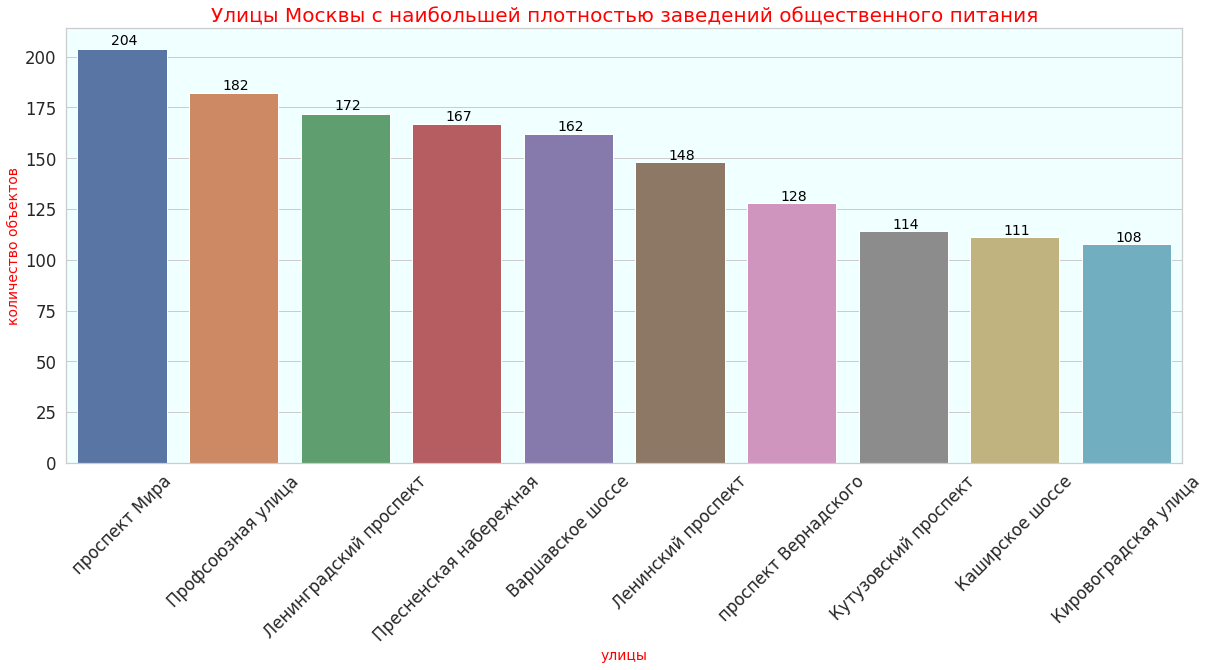

In [41]:
x='street'
y='obj_count'
dataset=top_ten_street
title='Улицы Москвы с наибольшей плотностью заведений общественного питания'
xlabel='улицы'
ylabel='количество объектов'
plot_attr(x,y,dataset,title,xlabel,ylabel,rotation=45)

Нанесем на карту адреса заведений общепита, расположенных на улицах г.Москвы из ТОП-10.

In [42]:
title = 'Улицы Москвы с наибольшей плотностью заведений общественного питания'
title_html = '''
             <h3 align="center" style="font-size:20px; color:red"><b>{}</b></h3>
             '''.format(title)   
m = folium.Map(location=(55.74, 37.6156),zoom_start=10,min_zoom=10,max_zoom=13, tiles='openstreetmap')
m.get_root().html.add_child(folium.Element(title_html))
top_ten_street_coord.apply(lambda x:folium.Circle([x.longitude,x.latitude], radius=2, color='red').add_to(m),axis=1)
m

Улицы с наибольшей концентрацией заведений общественного питания расположены в Северном и Северо-Восточном АО, а так же Центральном, Западном и Южном АО. Это радиальные магистрали, совпадающие с основными туристическими маршрутами.



---



Определим улицы г. Москвы, адресно имющие только один объект общественного питания.

In [43]:
one_obj_street=street_dist_city[street_dist_city['obj_count']==1]['street'].reset_index(drop=True)

In [44]:
print('Улиц в г.Москва с одним заведением общественного питания: ',one_obj_street.count())

Улиц в г.Москва с одним заведением общественного питания:  539


Нанесем на карту адреса заведений общепита, расположенных на улицах г.Москвы, являющиеся единственным объектом общественного питания.

In [45]:
title = 'Улицы Москвы с наименьшей плотностью заведений общественного питания'
title_html = '''
             <h3 align="center" style="font-size:20px; color:red"><b>{}</b></h3>
             '''.format(title)   
m = folium.Map(location=(55.7522, 37.6156),zoom_start=10,min_zoom=10,max_zoom=13, tiles='openstreetmap')
m.get_root().html.add_child(folium.Element(title_html))
one_obj_street_coords.apply(lambda x:folium.Circle([x.latitude,x.longitude], radius=2, color='red').add_to(m),axis=1)
m

Такие улицы расположены на всей территории г. Москвы, хотя наибольшая их плотность отмечена в центре города (здесь улицы имеют длины меньше средних).

---



### **Исследование распределения количества посадочных мест для улиц с большим количеством объектов общественного питания**

Сгруппируем заведения общепита, расположенные на улицах с самой большой конценрацией объектов, по количеству посадочных мест.

In [46]:
top_street_num=rest_data.query('street in @top_ten_street.street').groupby('number')['address'].count().reset_index()
top_street_num.columns=['number','count']

Средней вяляется вместимость в 58 мест, хотя в половине заведений количество посадочных мест не более 40. Следовательно, размеры заведений на улицах г. Москвы с наибольшей концентрацией объектов общественного питания не отличаются от средних по городу.

In [47]:
rest_data.query('street in @top_ten_street.street').number.describe()

count    1496.00
mean       58.23
std        90.21
min         0.00
25%        12.00
50%        40.00
75%        75.00
max      1700.00
Name: number, dtype: float64

In [48]:
print("В 90% заведений, расположенных на улицах из ТОП-10, количество посадочных мест не превышает: ", int(np.ceil(np.percentile(rest_data.query('street in @top_ten_street.street').number, 90))))

В 90% заведений, расположенных на улицах из ТОП-10, количество посадочных мест не превышает:  139


Отразим распределение объектов общественного питания на улицах г. Москвы из ТОП10 по вместимости на графике.

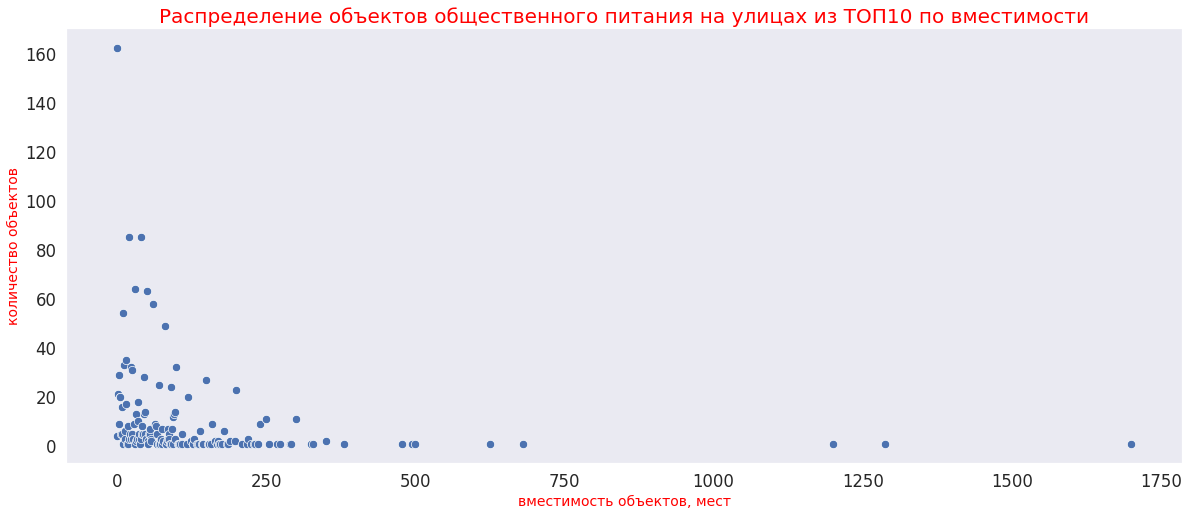

In [49]:
x=top_street_num.number
y=top_street_num['count']
title='Распределение объектов общественного питания на улицах из ТОП10 по вместимости'
xlabel='вместимость объектов, мест'
ylabel='количество объектов'
scat_attr(x,y,title,xlabel,ylabel)


Типичным для заведений общественного питания на улицах из ТОП-10 является количество посадочных мест, лежащее в диапазоне от 0 до 250.

In [50]:
print("Доля заведений на улицах из ТОП10 без зала для обслуживания клиентов: {:.1%}".format(top_street_num.query('number==0')['count'].values[0]/top_street_num['count'].sum()))

Доля заведений на улицах из ТОП10 без зала для обслуживания клиентов: 10.8%




---
Исследуем популярность форматов заведений на улицах г. Москвы с наибольшей плотностью расположения объектов общественного питания. Для этого сгруппируем данные по виду объектов и построим график.


In [51]:
top_street_num=rest_data.query('street in @top_ten_street.street').groupby('object_type')['address'].count().reset_index()
top_street_num.object_type=top_street_num.object_type.replace(['магазин (отдел кулинарии)','предприятие быстрого обслуживания'],['кулинария','фаст-фуд'])
top_street_num.columns=['object_type','count']

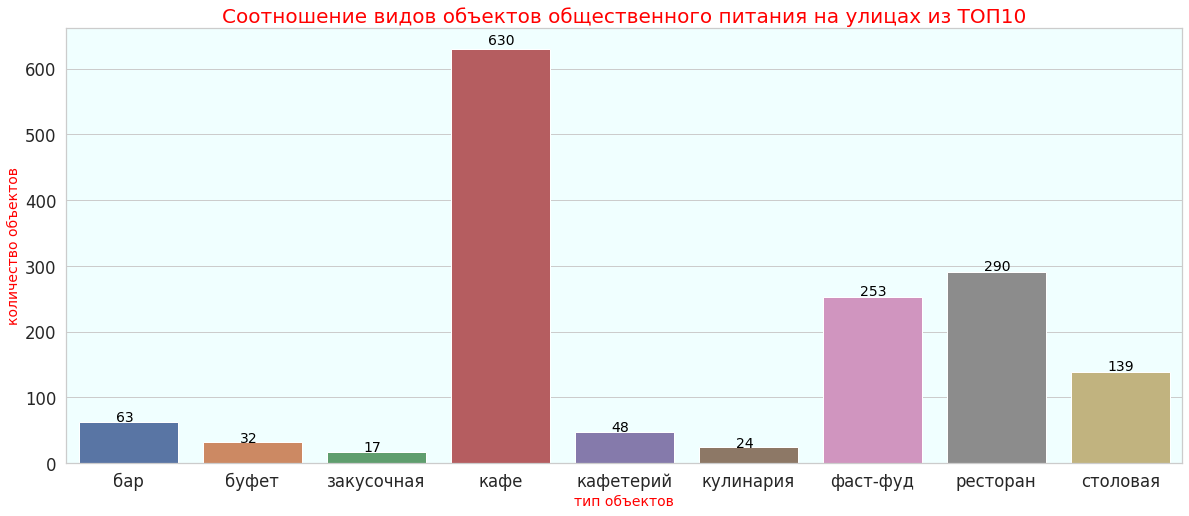

In [52]:
x='object_type'
y='count'
dataset=top_street_num
title='Соотношение видов объектов общественного питания на улицах из ТОП10'
xlabel='тип объектов'
ylabel='количество объектов'
plot_attr(x,y,dataset,title,xlabel,ylabel) 

Формат кафе наиболее предствален на улицах г. Москвы, входящих в ТОП-10.

---



## **Выводы и рекомендации**<a  class="anchor" id="summary"></a>

Общественное питание в г. Москва обеспечивается заведениями всех форматов. Ниаболщее распространие получили объекты типа "кафе", "ресторан", "предприятие быстрого обслуживания" (фаст-фуд) и "столовая". 

В реднем около 1/5 всех заведений общепита входят с состав сетей. Для наиболее популярных форматов характерна  даже большая доля сетевой крнцентрации: более 40% для фаст-фуда и 22-23% для рестранов и кафе. Столовые обычно не входят в состав сетей, так как ориентированы в основном потребности в организации питания, сложившиеся в конкретном месте.

Средняя вместимость объектов общественного питания г. Москвы составляет 60 посадочных мест (медианная - 40). Сетевые заведения ощепита, как правило, имеют такую же вместимость.

По видам объектов общественного питания наибольшая средняя вместимость отмечена для столовых и ресторанов 131 и 97 мест соотвественно. Для заведений остальных форматов средняя вместимость не превышает 52 мест.

Наибольшая концентрация заведений общественного питания отмечается на радиальных магистралях берущих свое начало от Садового кольца, расположенных в Северно и Северо-Западном АО, Центральном, Западном и Южном АО. Средние значения вместимости и доля заведений не имеющих зала для обслуживания посетителей для объектов, расположенных на улицах из ТОП-10, правктически не отличается от среднегородских.
Для этих улиц наиболее популярным фрматом общепита является кафе, в первую тройку входят предприятия быстрого обслуживания и рестораны.

**Рекомендации**

Соглано концепции нашего проекта, основным якорем для клиентов будет являться интерактивность, обусловленная формой обслуживания посетителя в зале. Из всех видов заведений общественного питания только рестораны (полностью), кафе (частично) и бары (частично) сочитают производство, реализацию и организацию потребления продукции с организацией отдыха и развлеченний потребителя (ГТСТ  Р 50762-95).

Из указанных типов формат традиционного бара не подходит по причине высокой вероятности возникновения конфликтных ситуаций в процессе функционирования, сложности обслуживания потребителей в зале при высокой мобильности последних, потенциально повышенных затрат на алгоритмизацию поведения и обслуживание роботов-официантов.

Гипотетическими группами посетителей в порядке скорости оттока по мере нивелирования для клиента основного привлекающего фактора заведения, обслуживаемого роботами, считаем следующие:
- жители столицы и области, следящие за новинками общественной жизни;
- гики, представители техно-субкультур и молодые люди, интересующиеся техническими новинками;
- туристы и гости столицы.

Интерактивность окружения посетителей будет обеспечиваться в случае частых пермещений роботов-официантов, что достигается простыми, стандартизированными заказами с быстрым приготовлением и подачей. Следовательно, наиболее подходящим форматом заведения стоит признать кафе.

Основными преимуществами кафе по сравнению с рестораном являются:

**1)** Меньшие затраты площади на одно посадочное место и меньшая регламентируемая площадь парковки. 

Согласно Московских городских строительных норм (МГСН 4.14-98) для кафе площадь на одно посадочное место обеденного зала должна составлять 1,6 кв. м.  и должно быть пердусмотрено одно парковочное место на 12 посадочных мест. Соотвественно для ресторана: 1,8 кв.м. и одно место парковки на 12 посадочных мест. 
Для заведения, облуживаемого роботами, потребуется неизбежное увеличение норм площади на одно посадочное место для обеспечения качества и безопасности обслуживания.

**2)** Более высокая оборачиваемость посадочных мест для кафе.

Это приведет как к повышению привлекательности основной "фишки" заведения, так и привлечет больше клиентов, ограниченных во времени на посещение объектов общественого питания (туристических групп).

**3)** Совпадение традиционного графика работы кафе (с 10:00 до 22:00) с временем "активности" целевой аудитории.

Согласно упомянутым МГСН, оптимальной всестимостью кафе для г. Москвы принято 50-200 посадочных мест. Исходя из полученных в результате анализа данных и учитывая тот факт, что для заведения, в обеденном зале которого помимо посетителей предусмотрено присутствие и работа машин, считаем целесообразным предложить ограничить вместимость 50 посадочными местами.

По результатам исследования улиц г. Москвы, имеющих наибольшую концентрацию объектов общественного питания, и учитывая "высоко-технологичную" специфику заведения, предлагаем рассмотреть для размещения проспект Мира в районе Останкино и ВДНХ (наименьшая плотность кафе и ресторанов на наиболее охваченной ими улице).

Концепция кафе, роль официантов в котором исполняют роботы, имеет высокий потенциал развития в сеть:
- концепты кафе хорошо транслируются территориально (доля сетевых кафе на карте г. Москвы выше средней доли сетевых заведений общепита);
- формат исключает различия в качестве обслуживания между филиалами (отсутствует лимитриующий фактор квалификации обслуживающего персонала);
- локализация нового места размещения может быть проведена довольно точно на основе знания маршрутов целевой аудитории, генерирующей основной поток на длительную перспективу.

<a href='https://drive.google.com/file/d/1FryM6u8NUOufqmOMk3SxVZOqEN3CQ93E/view?usp=sharing'> Файл презентации </a>